In [1]:
import cv2 
import torch
import numpy as np
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import yaml
from dataset import TrafficLightDataset, collate_fn
from model import trafficLightDetectionModel
from train import train_one_epoch
from os.path import exists
from torchvision.ops import box_iou

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


In [2]:
img_dir = "/home/alexlin/traffic_net/dataset_train_rgb/"
labels_dir = "/home/alexlin/traffic_net/dataset_train_rgb/train.yaml"
classes = ['background', 'GreenLeft', 'RedStraightLeft', 'RedLeft', 'off', 'GreenStraight', 'GreenStraightRight',
             'GreenStraightLeft', 'RedStraight', 'GreenRight', 'Green', 'Yellow', 'RedRight', 'Red']

dataset = TrafficLightDataset(img_dir, labels_dir, classes)
train_data = torch.utils.data.DataLoader(
    dataset,
    batch_size=1,
    shuffle=False,
    num_workers=16, 
    collate_fn=collate_fn
)
data_list = list(train_data)

        

In [4]:
print(data_list[2][1][0])

{'boxes': tensor([[244.2500, 140.6000, 246.3000, 143.4500],
        [253.5500, 136.9000, 255.2500, 140.4000],
        [259.8000, 140.1500, 262.0000, 144.3000]]), 'labels': tensor([11, 11, 11])}


In [3]:
model = trafficLightDetectionModel(num_classes=len(classes)).to(device)


In [4]:
start_epoch = 0
epoch = 8
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005)
lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15, 20, 25, 30], gamma=0.5)
losses = []
if exists('checkpoints/last_checkpoint.pt'):
    checkpoints = torch.load('checkpoints/last_checkpoint.pt')
    start_epoch = checkpoints['epoch']
    model.load_state_dict(checkpoints['weights'])
    optimizer.load_state_dict(checkpoints['optimizer'])
    lr_scheduler.load_state_dict(checkpoints['lr_scheduler'])

for e in range(start_epoch+1, epoch):
    train_one_epoch(model, device, train_data, optimizer, e, losses)
    lr_scheduler.step()


In [6]:
states = {
            'epoch': e,
            'weights': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'lr_scheduler': lr_scheduler.state_dict(),
            'losses' : losses
        }
torch.save(states,'checkpoints/last_checkpoint.pt')

NameError: name 'e' is not defined

In [5]:
checkpoints = torch.load('checkpoints/last_checkpoint.pt')
start_epoch = checkpoints['epoch']
model.load_state_dict(checkpoints['weights'])
optimizer.load_state_dict(checkpoints['optimizer'])
lr_scheduler.load_state_dict(checkpoints['lr_scheduler'])
losses = checkpoints['losses']

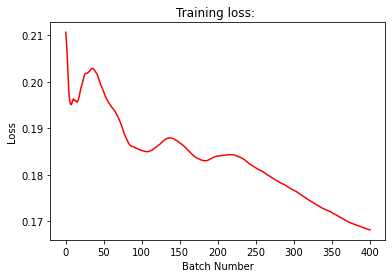

In [17]:
def smooth(x, size):
    return np.convolve(x, np.ones(size)/size, mode='valid')

plt.plot(smooth(losses[:450],50), color='red')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.title("Training loss: ")
plt.show()

In [1]:
from predict import Predictor
p1 = Predictor(model, device)
img = p1.read_img('/home/alexlin/traffic_net/dataset_train_rgb/rgb/train/2015-10-05-10-52-01_bag/27860.png')
x = p1.process_img(img).to(device)
predictions = p1.predict(x)
p1.draw_image(img, predictions, classes)
while True:
    cv2.imshow('test', img)
    if cv2.waitKey(1) == 27: 
        break

cv2.destroyAllWindows()

NameError: name 'model' is not defined

In [21]:

model.eval()

average_recall = 0.
average_precision = 0.
average_f1_score = 0.
with torch.no_grad():
    for i in range(len(data_list)):
        x = data_list[i][0][0].to(device)
        predictions = model([x])
        predictions = predictions = {k: v.to(device)
                                for k, v in predictions[0].items()}
        y= data_list[i][1]
        labels = [{k: v.to(device) for k, v in t.items()}
                        for t in y]
        precision_score, recall_score, F1_score = accurracy(labels[0], predictions)
        average_recall += recall_score
        average_precision += precision_score
        average_f1_score += F1_score
        if (i+1) % 100 == 0:
            print(average_recall/(i+1))
            print(average_precision/(i+1))
            print(average_f1_score/(i+1) )

print(average_recall/len(data_list))
print(average_precision/len(data_list))
print(average_f1_score/len(data_list))

0.42
0.28170820845820854
0.1632898832751774
0.365
0.2575054879760762
0.14669309246337106
0.43333333333333335
0.3083415214604472
0.17572090119597317
0.4625
0.3429402139669082
0.19242205452652025
0.486
0.3728521711735267
0.2063645133459187
0.4766666666666667
0.36749423355369637
0.20304011906190428
0.4957142857142857
0.38031194282719655
0.21040267739334292
0.4875
0.36957970571805276
0.205328875366954
0.45555555555555555
0.3464642701950884
0.1923070584047472
0.458
0.35078050053456056
0.19412397865080305
0.45454545454545453
0.3487773014173559
0.1927742528266967
0.44
0.3388653040770207
0.186976269686108
0.44153846153846155
0.3405908667670668
0.187878265437347
0.4607142857142857
0.35456137059921766
0.1957866675759251
0.47733333333333333
0.3668158259799808
0.20259316523790247
0.48125
0.3696088240577561
0.2042612078574665
0.4835294117647059
0.36962315642630356
0.20439375275767552
0.48444444444444446
0.37167899246529795
0.2052329414966238
0.4763157894736842
0.3668946610474768
0.2022877212276632


In [19]:
def accurracy(gt, pred):
    prob_threshold = .5
    IOU_threshold = .5
    true_Positive_Counter = 0
    false_Positive_Counter = 0
    false_Negative_Counter = 0
    for i, box in enumerate(pred["boxes"]):
        if pred["scores"][i] > prob_threshold:
            pred_x_max = box[0]
            pred_x_min = box[1]
            pred_y_max = box[2]
            pred_y_min = box[3]
            for j, box_gt in enumerate(gt["boxes"]):
                gt_x_max = box_gt[0]
                gt_x_min = box_gt[1]
                gt_y_max = box_gt[2]
                gt_y_min = box_gt[3]

                xA = max(pred_x_min, gt_x_min)
                yA = max(pred_y_min, gt_y_min)
                xB = min(pred_x_max, gt_x_max)
                yB = min(pred_y_max, gt_y_max)

                interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

                predArea =  (pred_x_max - pred_x_min + 1) * (pred_y_max - pred_y_min + 1)
                gtArea = (gt_x_max - gt_x_min + 1) * (gt_y_max - gt_y_min + 1)

                iou = interArea / (predArea + gtArea - interArea)


                if iou > IOU_threshold:
                    if pred["labels"][i] == gt["labels"][j]:
                        true_Positive_Counter += 1
                    else :
                        false_Positive_Counter += 1
    
    tag = False
    if (true_Positive_Counter + false_Positive_Counter) == 0:
        precision_score = 0
    else :
        precision_score = true_Positive_Counter / (true_Positive_Counter + false_Positive_Counter)
    if (true_Positive_Counter + false_Negative_Counter) == 0:
        recall_score = 0
    else :
        recall_score = true_Positive_Counter / (true_Positive_Counter + false_Negative_Counter)
    if (precision_score + recall_score) == 0:
        F1_score = 0 
    else:
        F1_score =  precision_score * recall_score / (precision_score + recall_score)

    return precision_score, recall_score, F1_score